In [1]:
#import custom modules
from importlib import reload
from helpers.my_imports import *
import helpers.preprocessing as pp
import helpers.plot as plot
import helpers.tools as tools
import helpers.transformers as xfrs
from helpers.reload import myreload

#make sure latest copy of library is loaded
myreload()

#Global Variable for Random State
rs=42 #random_state

df = pd.read_csv('saved_dfs/preprocessed_negotiations_df.csv')
df.head(2)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,billed_amount,negotiation_amount,offer,counter_offer,decision,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer
0,HCFA,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 3,Cedar Hill,Cigna,3344605,FULLY,Zelis,Marissa Pepe,4058.0,4058.0,258.0,3449.0,Rejected,128.0,NaN,0.0,0.0,1984,1.0,0.0636,0.0748
1,UB,NNSA,No,NNSA Negotiation,Insurance Initiated,Level 5,Cedar Hill,Blue Cross Blue Shield,174518M3BH,SELF,Zelis,Courtney Kiernan,52253.0,52253.0,12500.0,44415.0,Rejected,127.0,NaN,2.0,2.0,2021,1.0,0.2392,0.2814


# Model Evaluation
- We performed HyperParameter Tuning on 5 models: `LogisticRegression`, `RandomForest`, `GradientBoostClassifier`, `MLPClassifier` and `KerasClassifier`.  While `LogisticRegression` scored slightly less than `GradientBoostClassifier`,  we still take a look at the `LogisticRegression` so we can inspect the most important coefficients. 
- It bears reiterating that not only did GradientBoostClassifier score slightly higher than LogisticRegression, it did so with Polynomial Degree = 1 which equates to a simpler model

## Define X, y

In [2]:
#Define X and y
X,y=df.drop(columns=['decision', 'billed_amount', 'negotiation_amount', 'offer', 'counter_offer']), df.decision

#Split and stratify the data
X_train, X_test, y_train, y_test = train_test_split(X,y, stratify=y, test_size=0.25, random_state=42)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((6398, 20), (2133, 20), (6398,), (2133,))

## Load Best Logistic Regression Model

In [59]:
best_lgr = load('models/hyperparam_tuning/ht_lgr_set7.joblib')
best_lgr

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('yeo',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(include_bias=False))]),
                                                  ['neg_to_billed',
                                                   'offer_to_neg',
                                                   'offer_to_counter_offer',
                                                   'offer_days',
                                                   'decision_days',
                                                   'service_days',
                                                   'counter_offer_days',
                                                   'YOB']),
                                                 ('cat',
                                                  Pip...
                ('scaler', RobustScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(max_iter=3000,
                                                              n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='saga'),
                                 threshold=1.235962471258738e-06)),
                ('lgr',
                 LogisticRegression(C=7.387641469840879,
                                    class_weight={'Accepted': 0.2086,
                                                  'Rejected': 1},
                                    max_iter=5000, n_jobs=-1, random_state=42,
                                    solver='newton-cholesky',
                                    tol=3.278628584511121e-05))])

#### Confirm we have the right model and that train and test scores match Hyperparameter Tuning

In [60]:
f1_score(y_train,best_lgr.predict(X_train), average='weighted'), f1_score(y_test,best_lgr.predict(X_test), average='weighted')

(0.9437384119789385, 0.9502788271866773)

### Retrieve and Interpret Coefficients
- Since this a binary classification problem, it is difficult to quantify how each coefficient impacts the decision (target) 
- Interpretation is further complicated by the fact that the numerical features were transformed using yeo-johnson transformation.  
- Nevertheless, below we show the top 15 coefficients that have the most predictive impact, along with the Standard Deviation. The results are listed by descending order of importance.  

In [176]:
#selected_features, discarded_features = tools.custom_get_feature_names(model)
myreload()
coef_df=tools.get_lgr_pipe_coefs(best_lgr, scaler_name='scaler', selector_name='selector')
coef_df.head(15)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


,Absolute Value of Coefficient,std_dev
offer_to_neg,4.12,2.08
offer_to_counter_offer,3.12,1.91
neg_to_billed offer_to_neg,2.97,1.55
offer_to_neg offer_to_counter_offer,1.71,2.48
in_response_to_Reconsideration Letter,1.55,1.00
neg_to_billed offer_to_counter_offer,1.54,1.42
offer_to_counter_offer counter_offer_days,1.37,1.55
offer_to_counter_offer^2,1.34,2.33
split_claim_Yes,1.19,1.00
claim_type_UB,1.13,1.00


### PRC Curve for best LogisticRegression Model

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


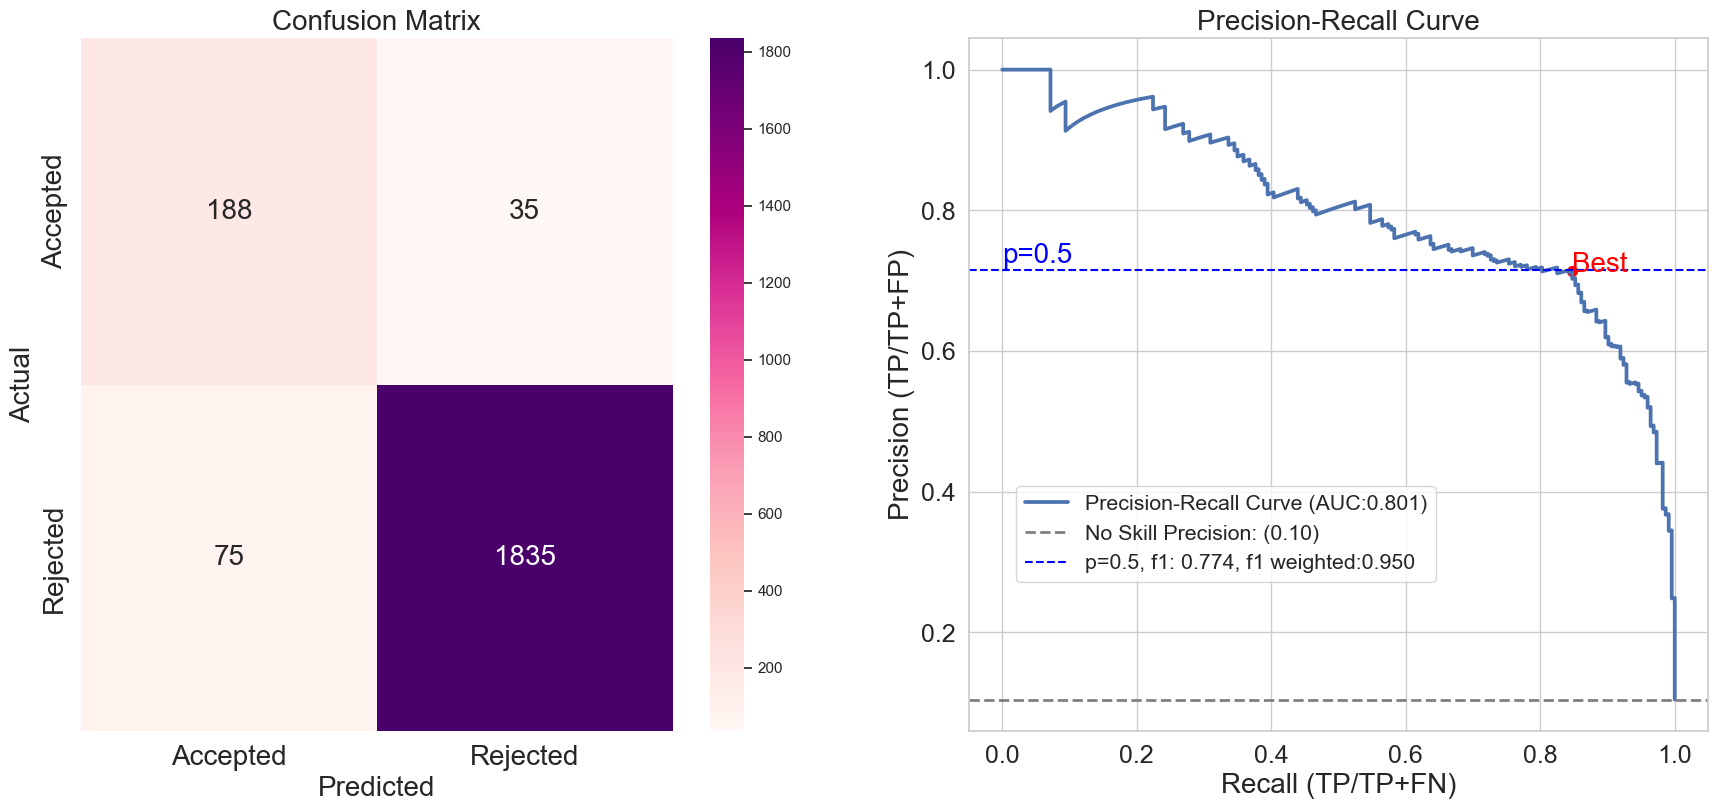

In [49]:
myreload()
plot.conf_matrix_PRC(best_lgr, X_test, y_test, probas_pos_index=0, threshold=0.5,
                     common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

#### Discuss Tradeoff on PRC Curve
- The PRC curve shows the tradeoff between Precision and Recall. As the threshold increases: 
    - Increased Precision, Decreased FPs
    - Decreased Recall, Increased FNs  

 - For example, below we show what happens when threshold is increased to 0.7.  FPs decrease from 75 to 52 whereas FNs increase from 35 to 86.  
 
#### Invitation to reader
The reader is invited to set the threshold to various values in the function below in order to get a sense of the tradeoff by seeing the effect on the FPs and FNs in the confusion matrix as well as where on the PRC curve the selected threshold lies.  We did this because the Billing Department has a slight leaning towards Precision over Recall.  This would allow the team to visualize what the tradeoff looks like at varying thresholds

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


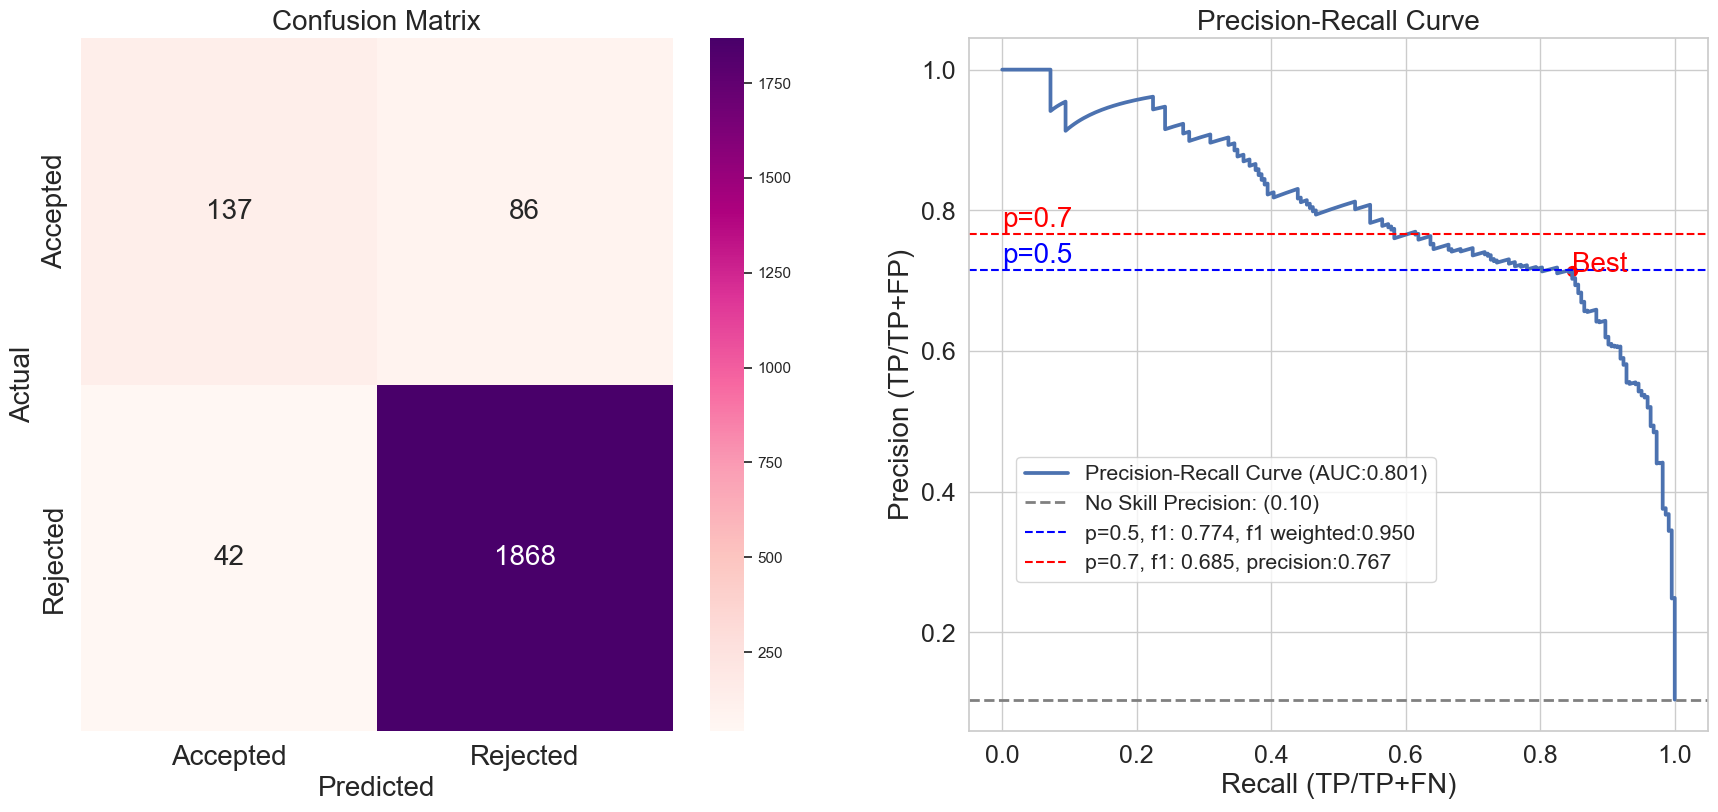

In [63]:
myreload()
plot.conf_matrix_PRC(best_lgr, X_test, y_test, probas_pos_index=0, threshold=0.7,
                     common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

### Lift and Cumulative Gains Curve for Best Logistic Regression Model
These charts show the advantage of using our predictive model to choose certain types of claims.  While this may prove difficult to do in reality, it does indicate that if as a health provider we are able to attract certain types of customers, we may be able to increase our Acceptance Rate. 

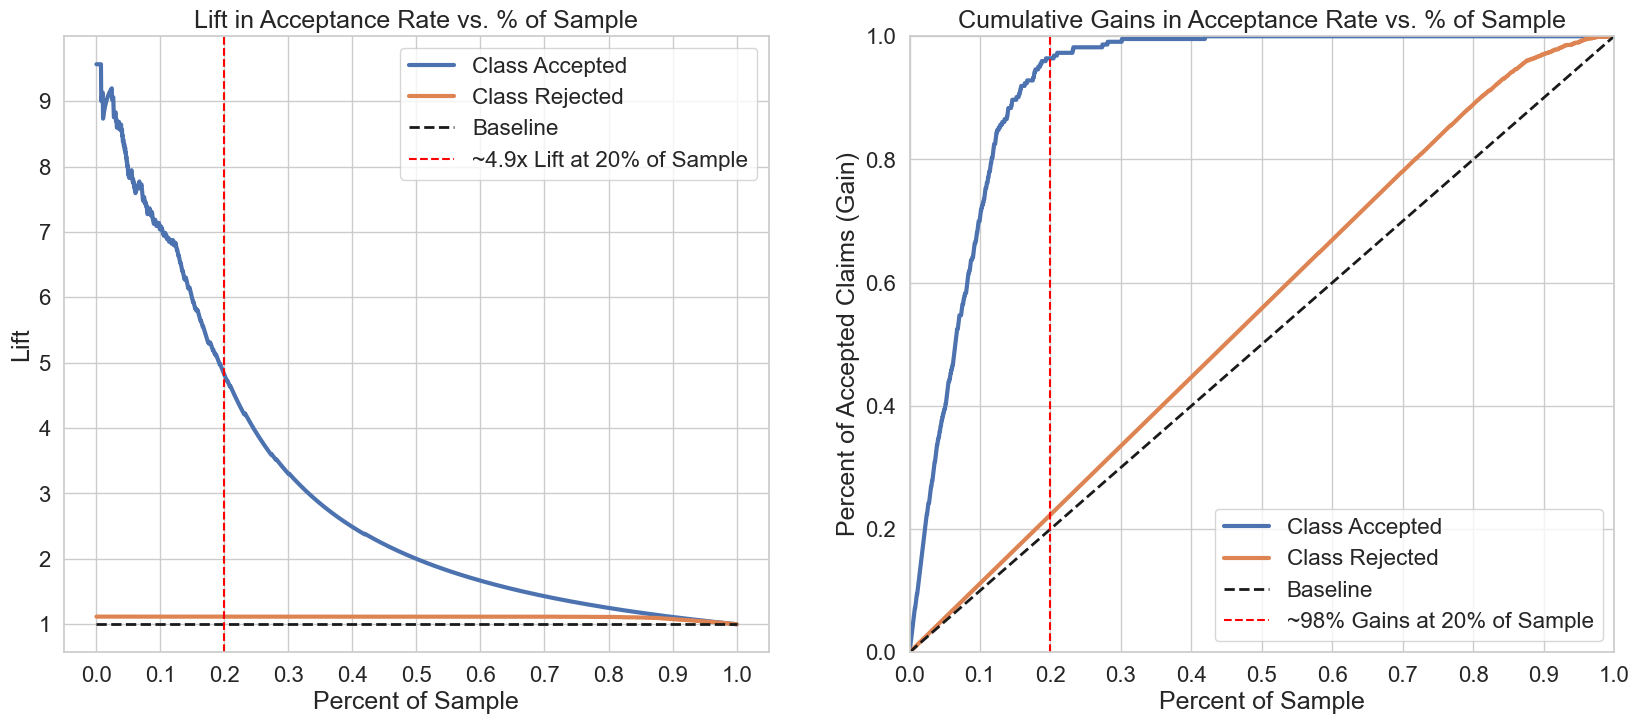

In [167]:
# Calculated predicted probabilities for test set
y_test_probas = best_lgr.predict_proba(X_test)

#Plot Lift and Cumulative Gains Curve
plot.lift_and_cumulative_gains(y_test, y_test_probas, 
                               lift_line_label='~4.9x Lift at 20% of Sample', 
                               lift_title='Lift in Acceptance Rate vs. % of Sample',
                               gains_line_label='~98% Gains at 20% of Sample', 
                               gains_title='Cumulative Gains in Acceptance Rate vs. % of Sample')

#### Lift Curve
- The Lift Curve shows that for the first 20% of our 'best' claims, we will have ~4.9x more Accepted negotiations than if we had selected claims at random 
- However, we do not know what claims belong to this group we are calling 'best'.  In order to explain this, we would need to use clustering methods such as k-means. 

#### Cumulative Gain Curve:
- We see we can obtain almost ~98% of the Accepted Negotiations with just 20% of our claims!  

## Load Best GradientBoostClassifier model (Also best overall)

In [65]:
best_gbc = load('models/hyperparam_tuning/ht_ens_set8.joblib')
best_gbc

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('si',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('yeo',
                                                                   PowerTransformer()),
                                                                  ('poly',
                                                                   PolynomialFeatures(degree=1,
                                                                                      include_bias=False))]),
                                                  ['neg_to_billed',
                                                   'offer_to_neg',
                                                   'offer_to_counter_offer',
                                                   'offer_days',
                                                   'decision_days',
                                                   'service_days',
                                                   'counter_offer_days',
                                                   'YOB']),
                                                 (...
                ('scaler', RobustScaler()),
                ('selector',
                 SelectFromModel(estimator=LogisticRegression(max_iter=3000,
                                                              n_jobs=-1,
                                                              penalty='l1',
                                                              random_state=42,
                                                              solver='saga'))),
                ('gbc',
                 GradientBoostingClassifier(learning_rate=0.004, max_depth=2,
                                            max_features='sqrt',
                                            min_samples_leaf=48,
                                            min_samples_split=0.013750000000000002,
                                            n_estimators=3700, random_state=42,
                                            subsample=0.85))])

#### Confirm we have the right model and that train and test scores match Hyperparameter Tuning

In [66]:
#Define X and y in such a way as to support the catboosed encoder
X_gbc, y_gbc = X.copy(deep=True), y.copy(deep=True) 
X_gbc[X_gbc.select_dtypes(exclude=['number']).columns] = X_gbc.select_dtypes(exclude=['number']).astype('str')
y_gbc = y_gbc.map({'Accepted':1, 'Rejected':0})

In [54]:
#Split and stratify the data
X_train_gbc, X_test_gbc, y_train_gbc, y_test_gbc = train_test_split(X_gbc,y_gbc, stratify=y_gbc, test_size=0.25, random_state=42)
X_train_gbc.shape, X_test_gbc.shape, y_train_gbc.shape, y_test_gbc.shape

((6398, 20), (2133, 20), (6398,), (2133,))

In [55]:
#Calculate predicted train and test target
y_pred_train = best_gbc.predict(X_train_gbc)
y_pred_test = best_gbc.predict(X_test_gbc)

# Calculating F1 score
f1w_train_gbc = f1_score(y_train_gbc, y_pred_train, average='weighted')
f1w_test_gbc = f1_score(y_test_gbc, y_pred_test, average='weighted')
f1w_train_gbc, f1w_test_gbc

(0.9513199673150076, 0.951527642572098)

### GBC Model Evaluation 
No coefficients exist for this model but we can still examine the confusion matrix and Precision-Recall Curve for our best_gbc model

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


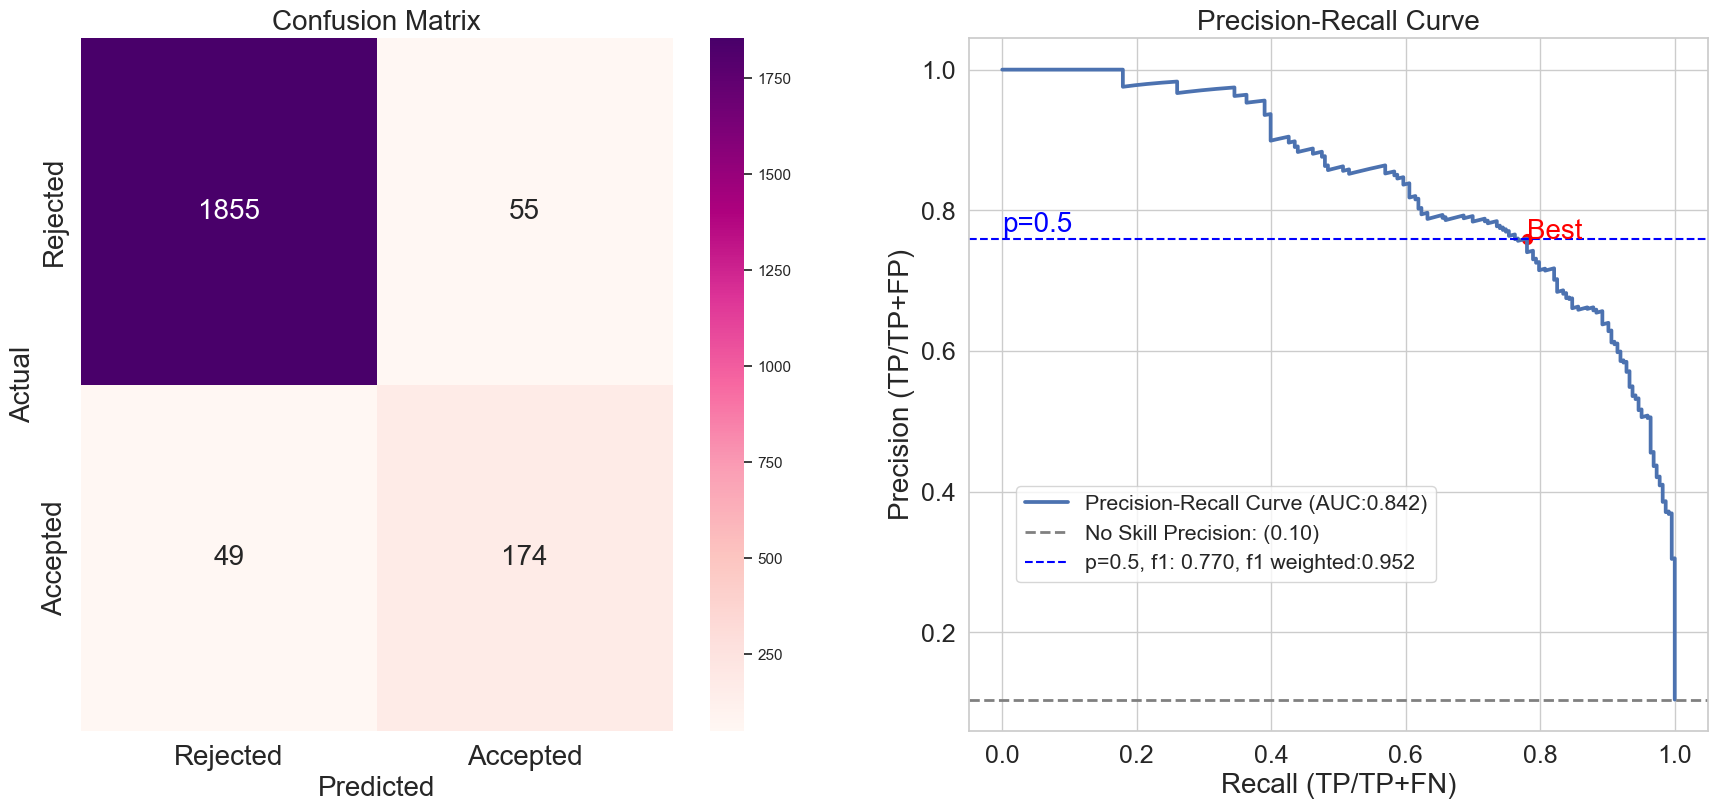

In [68]:
myreload()
plot.conf_matrix_PRC(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1, class_labels=['Rejected', 'Accepted'], 
                     threshold=0.5,common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

Once again, the PRC curve shows the tradeoff between Precision and Recall.  Below we show for instance that we can achieve **0 FPs** at a threshold of 0.88 but only at a cost of increased FNs (183 FNs vs. 49 at p=0.5) 

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


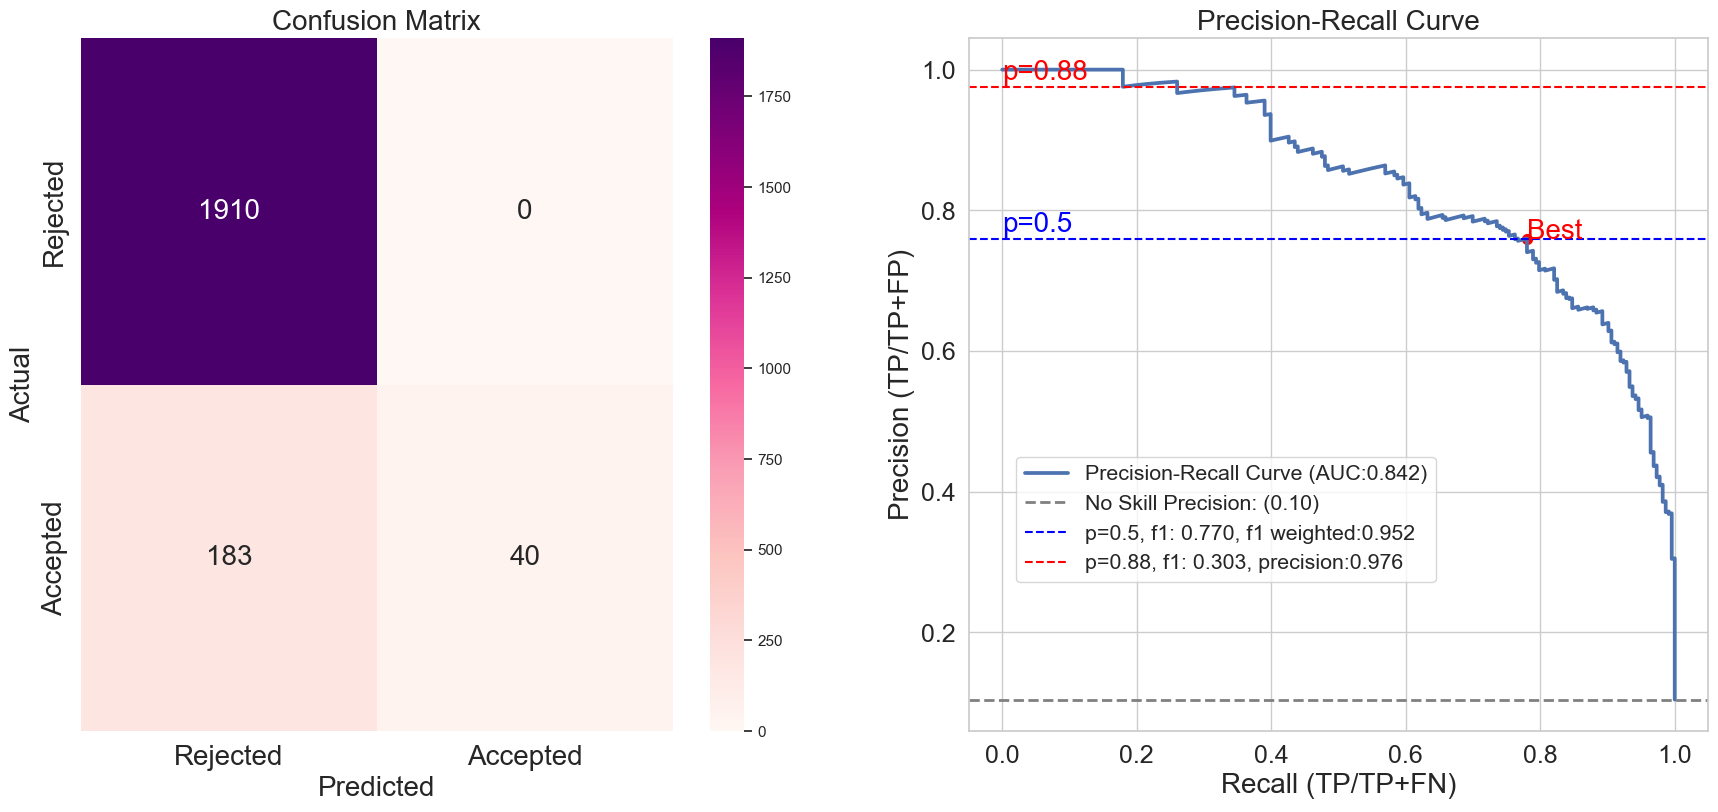

In [69]:
myreload()
plot.conf_matrix_PRC(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1, class_labels=['Rejected', 'Accepted'], 
                     threshold=0.88,common_fontsize=20, figx=21, figy=9, xlegend=0.05, ylegend=0.2) 

The graph below shows the behavior of Precision, Recall and F1 vs. Thresholds

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


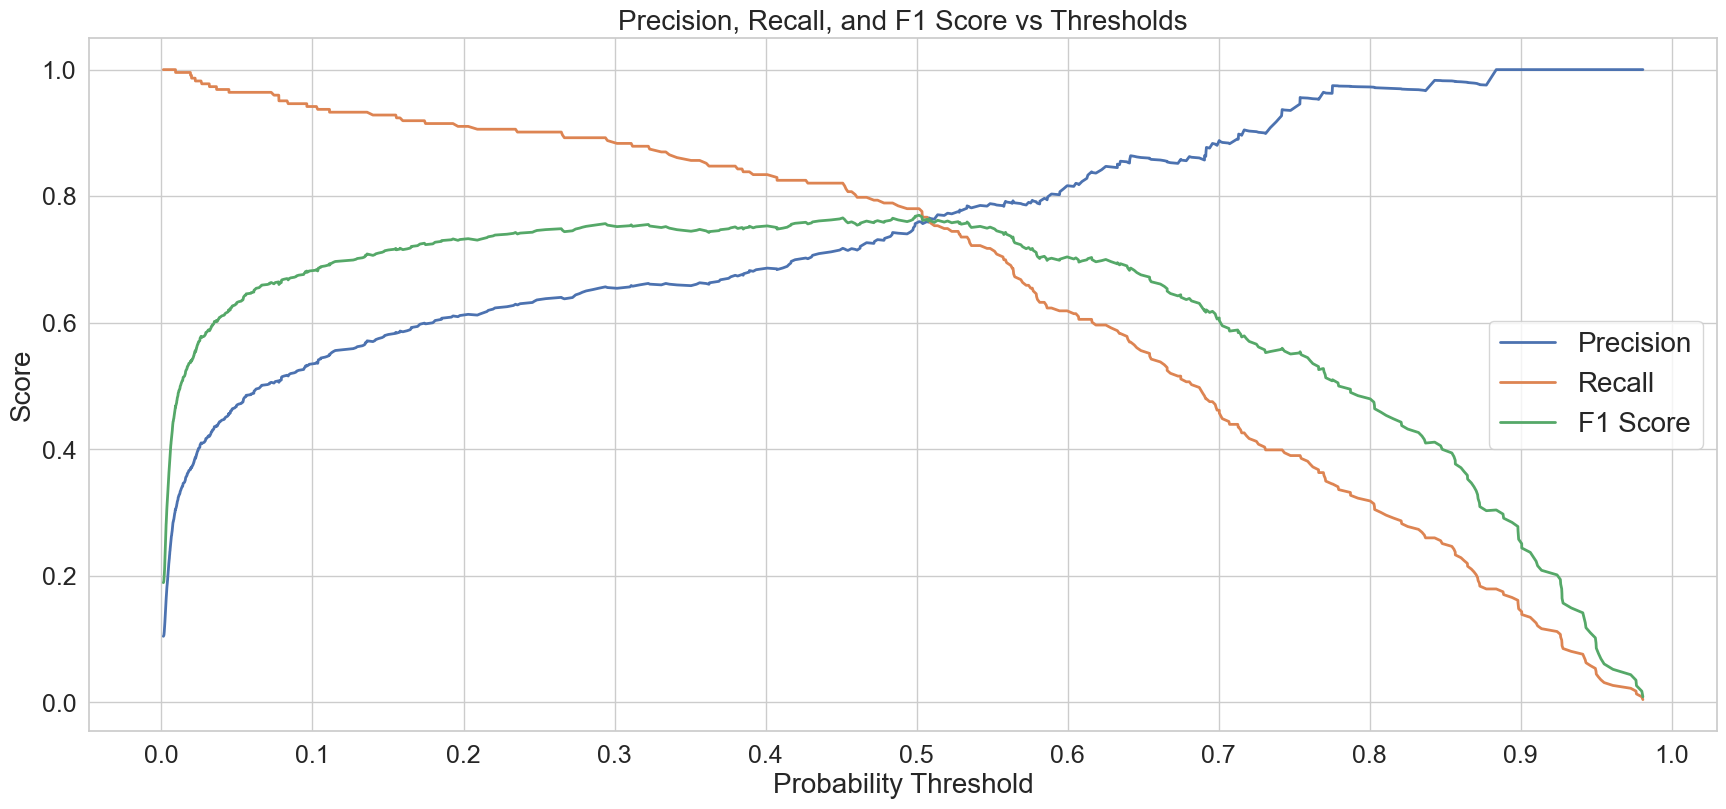

In [71]:
myreload()
plot.scores_vs_thresholds(best_gbc, X_test_gbc, y_test_gbc, probas_pos_index=1,  
                    common_fontsize=20, figx=21, figy=9)

### Lift and Cumulative Gains Curves for Best Gradient Boost Model (Best overall)

Reloaded helpers.preprocessing, helpers.plots, and helpers.tools.


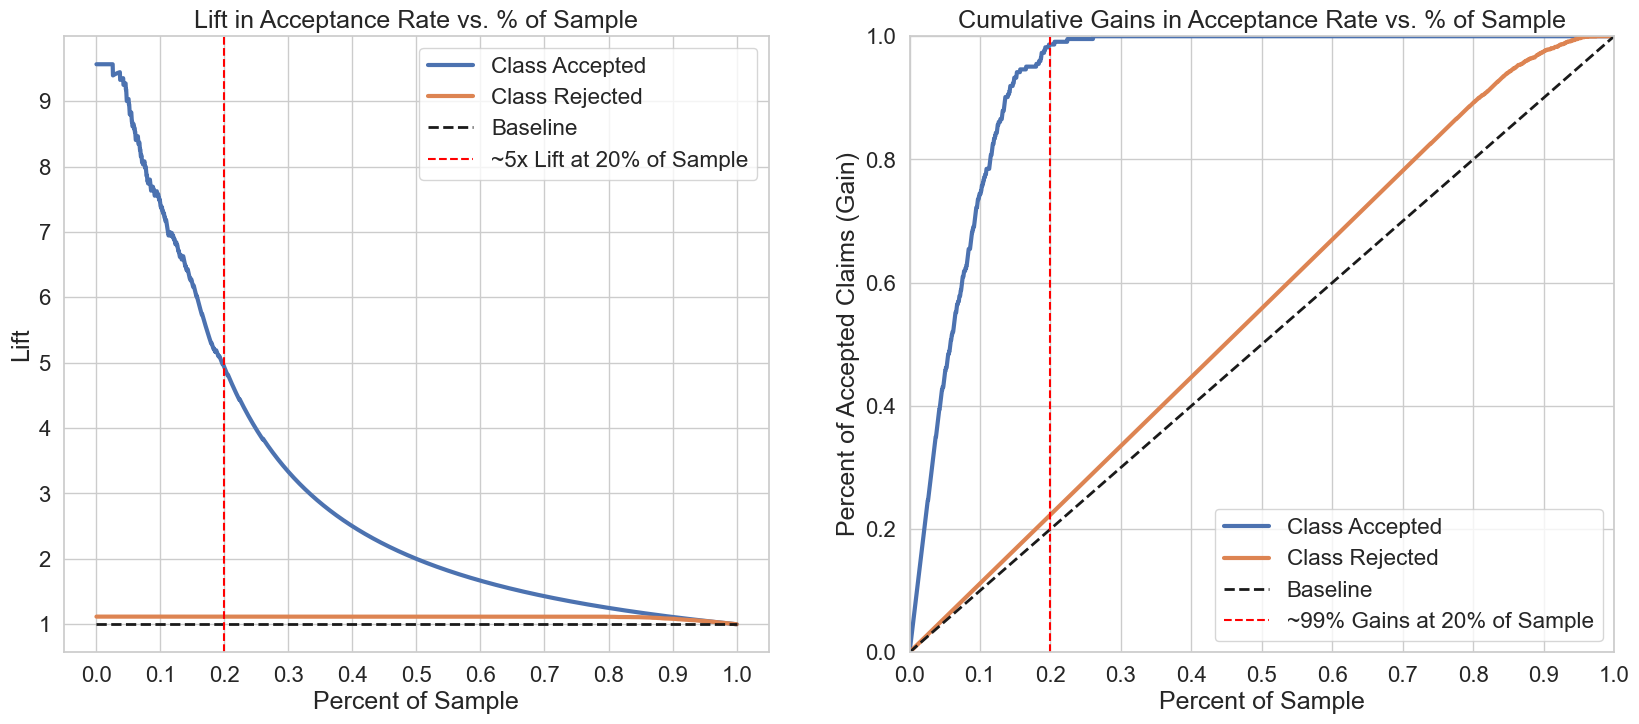

In [164]:
# Calculated predicted probabilities for test set
y_test_probas = best_gbc.predict_proba(X_test)[:, ::-1]

myreload()
plot.lift_and_cumulative_gains(y_test, y_test_probas, 
                               lift_line_label='~5x Lift at 20% of Sample', 
                               lift_title='Lift in Acceptance Rate vs. % of Sample',
                               gains_line_label='~99% Gains at 20% of Sample', 
                               gains_title='Cumulative Gains in Acceptance Rate vs. % of Sample')

#### Lift Curve
- The Lift Curve shows that for the first 20% of our 'best' claims, we will have ~5x more Accepted negotiations than if we selected random claims. 
- However, we do not know what claims belong to this group we are calling 'best'.  In order to explain this, we would need to use clustering methods such as k-means. 

#### Cumulative Gain Curve:
- We see we can obtain almost ~99% of the Accepted Negotiations with just 20% of our claims!  

## Counter Factuals 

In [98]:
#Recreate our dataset and store it in CF_df.  We drop the unused amount columns and we drop nulls
CF_df=df.copy(deep=True).dropna().drop(columns=['billed_amount', 'negotiation_amount', 'offer', 'counter_offer'])

In [99]:
# Step 1: dice_ml.Data
import dice_ml
from raiutils.exceptions import UserConfigValidationException
d = dice_ml.Data(dataframe=CF_df, continuous_features=['neg_to_billed', 'offer_to_neg', 'offer_to_counter_offer'], 
                 outcome_name='decision')

In [100]:
# Step 2: setup the model
m = dice_ml.Model(model = best_gbc, backend = "sklearn")

In [101]:
# Step 3: generate counterfactuals
exp = dice_ml.Dice(d, m)

e1 = exp.generate_counterfactuals(X_test[0:1],
                             total_CFs = 2,
                             desired_class = "opposite")

100%|█████████████████████████████████████████████| 1/1 [00:00<00:00,  2.52it/s]


In [102]:
e1.visualize_as_dataframe()

Query instance (original outcome : 0)


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer,decision
0,HCFA,NSA,No,Open Negotiation,Open Negotiation Notice,Level 4,Cedar Hill,United Health Care,690100,Unknown,Multiplan,Joanne Phelps,120.0,35.0,17.0,17.0,1978,1.0,0.0546,0.0728,0



Diverse Counterfactual set (new outcome: 1.0)


,claim_type,NSA_NNSA,split_claim,negotiation_type,in_response_to,level,facility,carrier,group_number,plan_funding,TPA,TPA_rep,service_days,decision_days,offer_days,counter_offer_days,YOB,neg_to_billed,offer_to_neg,offer_to_counter_offer,decision
0,HCFA,NSA,No,Open Negotiation,Open Negotiation Notice,Level 4,Cedar Hill,United Health Care,690100,Unknown,Multiplan,Julie H.,120.0,35.0,17.0,17.0,1978,1.0,0.634,0.8662,1
1,HCFA,NSA,No,Open Negotiation,Open Negotiation Notice,Level 4,Cedar Hill,United Health Care,2500181,Unknown,Multiplan,Joanne Phelps,120.0,35.0,17.0,17.0,1978,1.0,0.9456,0.625,1


## Summary of Model Evaluation Findings
### Coefficients
- We showed the coefficients of our best Logistic Regression Model even though we had a better GradientBoostClassifier Model.  This was done to show the relative importance of the features. The features were listed from most important to least important.  
- Ability to interpret the features themselves and their effect on the target is limited due to the fact that numerical values underwent a yeo-johnson transformation and also because we have a binary classification problem which means we cannot speak in terms of an increase or decrease in the target like we can with a Regression problem.

### Precision-Recall Tradeoff 
- We also showed the confusion matrix and Precision-Curves for our best Logistic Regression Models and our best overall (GBC) model.  
- For both models, we invited the reader to set the threshold to various values in order to get a sense of the tradeoff by seeing the effect on the FPs and FNs in the confusion matrix as well as where on the PRC curve the selected threshold lies.  We did this because the Billing Department has a slight leaning towards Precision over Recall.  This allows the team to visualize what the tradeoff looks like at varying thresholds

### Lift and Cumulative Gains Curve for best Model
- The Lift Curve for our GBC model shows that for the first 20% of our 'best' claims, we will have ~5x more Accepted negotiations than if we selected random claims. 
- However, we do not know what the characteristics of those claims we are calling 'best'are.  In order to explain this, we would need to use clustering methods such as k-means. 
- In the Cumulative Gains Curve, we see we can obtain almost ~99% of the Accepted Negotiations with just 20% of our claims! 

### Counter Factuals
- Two Counter Factuals for the first sample were explored: 
1. All features being the same, but increasing the offer_to_neg ratio from 0.0546 to 0.634 and increasing the offer_to_counter_offer ratio from 0.0728 to 0.8662 (likely to occur with a change in TPA_rep) would have resulted in changing the outcome from Rejected to Accepted.  
2. All features being the same, but increasing the offer_to_neg ratio from 0.0546 to 0.9456 and increasing the offer_to_counter_offer ratio from 0.0728 to 0.625 (likely to occur with a change in group_number) would have resulted in changing the outcome from Rejected to Accepted.  

## Summary of Non-Technical Findings (Findings Only)
We have built a Machine Learning model to predict the outcome of negotations. We share our main findings below: 
- Out of 2133 claims that we tested our best model, the model predicted:
    - 2029 negotiation decisions correctly 
    - 55 negotiations as Accepted that were actually Rejected
    - 49 negotiations as Rejected that were actually Accepted
- The most important aspects of the claim that affect predictability (in descending order) are: Offer to Negotgiation Amount ratio, Offer to Counter offer Ratio, Negotiation Amount to Billed Amount, Was the claim initiated in response to a Reconsideration Letter or some other action taken by us?, Was it a Split Claim? Was it a UB claim?  How many days before the deadline did we receive the offer?  There are of course other factors but these are the most important ones. Unfortunately with the exception of who initiated the claim, these factors are not something we control.  
- If we were able to group our claims by Acceptance Rate, we would find that the first 20% of our 'best' claims have ~5x more Accepted negotiations than if we select a claim at random. Unfortunately, we do not yet know what  the characteristics of those claims we are calling 'best'claims.  In order to explain this, we would need to conduct additional research. If we are successful with this research, we can potentially obtain almost ~99% of the Accepted Negotiations with just 20% of our claims! 
    

## Actionable Items, Recommendations and Next Steps (Non-Technical)
- If/whenever possible, we should initiate claims ourselves rather than let the Insurance companies initiate them because this increases the Acceptance Rate. 
- Perform a study to identify profiles of claims that would result in higher than average acceptance rates
- Build data validations to improve the quality of the data. For example, check if the offer amount is greater than the negotiation amount or billed amount before allowing a record to be saved.
- As an organization, we need to make a business decision on whether we wish to tune our model to increase the confidence level (e.g. 80% confidence) even though this would result in more claims predicted as Rejections that are actually Acceptances
- In order for this project to be useful, we would recommend building an application that would take all the fields in a claim including the offer amount and predict the negotiation decision. 
- Update our data with new claim samples 2 to 3 times a year and retrain and tune the model 
- Based on our work, we can take an already rejected claim and show by how much the ratio fields or number of days features would have needed to change to bring about an Acceptance. This counter-factual information may be useful for us to study going forward, in order to develop a guidance chart for the team